In [1]:
import os 
import sys 
import time 
import numpy as np
import json
import tpch_training as tp 

In [2]:
DET_PARAMS_FNAME = "./training_params/detparams_9.json"
DET_PARAMS = None
with open(DET_PARAMS_FNAME, 'rb') as f:
    DET_PARAMS = json.load(f)
    print(len(DET_PARAMS))

training_fnames = ['./training_results/'+x for x in os.listdir('./training_results') if 'txt' in x and 'det' in x]
len(training_fnames)
print(training_fnames)

def get_spark_params(result_dict):
    param_vals = []
    for param in tp.SPARK_PARAMETERS:
        for p in result_dict['params']:
            if p['name'] == param['name']:
                param_vals.append(p['cur_value'])
    return tuple(param_vals)

880
['./training_results/sf10_det_local_individual_job.txt', './training_results/sf10_det_main_det.txt', './training_results/sf10_det_test_logging.txt', './training_results/sf10_det_test_log_det.txt', './training_results/sf324_det_test_big_log_det.txt']


In [3]:
defaults = tuple(a['default_value'] for a in tp.SPARK_PARAMETERS)
defaults

(1,
 '1g',
 2,
 1,
 '1g',
 '48m',
 'true',
 'true',
 '32k',
 '4m',
 'true',
 0.6,
 '128',
 'false',
 'lz4',
 1,
 200,
 200,
 0.5)

In [12]:
fname_numdata = {}
fname_numdet = {}
deterministic_data = {}

for fname in training_fnames:
    with open(fname,'r') as file:
        lines = file.readlines()
        fname_numdata[fname] = len(lines)
        deterministic_data[fname] = {}
        
        for k in DET_PARAMS:
            if int(k) < len(lines):
                deterministic_data[fname][k] = eval(lines[int(k)])
        fname_numdet[fname] = len(deterministic_data[fname])
        if fname_numdet[fname] < 5:
            del fname_numdet[fname]
            del deterministic_data[fname]
            
print(sum(fname_numdata.values()))
print(fname_numdata)
print(fname_numdet)

2293
{'./training_results/sf10_det_local_individual_job.txt': 0, './training_results/sf10_det_main_det.txt': 532, './training_results/sf10_det_test_logging.txt': 1, './training_results/sf10_det_test_log_det.txt': 880, './training_results/sf324_det_test_big_log_det.txt': 880}
{'./training_results/sf10_det_main_det.txt': 532, './training_results/sf10_det_test_log_det.txt': 880, './training_results/sf324_det_test_big_log_det.txt': 880}


In [13]:
det_params = {}
det_rt = {}
for fname, data in deterministic_data.items():
    det_params[fname] = []
    det_rt[fname] = []
    for result_dict in data.values():
        det_params[fname].append(get_spark_params(result_dict))
        if result_dict['runtimes']:
            det_rt[fname].append(result_dict['runtimes']['total'])
    if not det_params[fname]:
        print(fname)
        del det_params[fname]
        del det_rt[fname]
prev_fname = fname
for fname in det_params:
    assert det_params[fname][0] == defaults, f'{det_params[fname][0]} !=\n{defaults}'
    #assert str(det_params[fname]) == str(det_params[prev_fname]), fname + " " + prev_fname
    print(fname, '\n',det_rt[fname][0], det_rt[fname][-1], max(det_rt[fname]), min(det_rt[fname]), len(det_rt[fname]))

./training_results/sf10_det_main_det.txt 
 69.89695191383362 78.75397205352783 87.17257952690125 61.32675647735596 532
./training_results/sf10_det_test_log_det.txt 
 1.310380458831787 1.3695781230926514 1.7630729675292969 1.0664875507354736 870
./training_results/sf324_det_test_big_log_det.txt 
 2.104457139968872 1.9405386447906494 2.9220142364501953 1.3364307880401611 870


In [14]:
# how many different param combos have we tried?
fname_num_params = {}
fname_valid = {}
for fname in training_fnames:
    with open(fname,'r') as file:
        lines = file.readlines()
        fname_num_params[fname] = set()
        fname_valid[fname] = 0
        for result_dict in lines:
            result_dict = eval(result_dict)
            fname_num_params[fname].add(get_spark_params(result_dict))
            fname_valid[fname] += 1 if result_dict['runtimes'] else 0


In [15]:
print(sum([len(x) for x in fname_num_params.values()]))
for fname, vals in fname_num_params.items():
    print(fname[18:60], '\nnum unique params', len(vals), 'total runs',fname_numdata[fname] , 'valid runs', fname_valid[fname])

231
/sf10_det_local_individual_job.txt 
num unique params 0 total runs 0 valid runs 0
/sf10_det_main_det.txt 
num unique params 54 total runs 532 valid runs 532
/sf10_det_test_logging.txt 
num unique params 1 total runs 1 valid runs 1
/sf10_det_test_log_det.txt 
num unique params 88 total runs 880 valid runs 870
/sf324_det_test_big_log_det.txt 
num unique params 88 total runs 880 valid runs 870


In [16]:
#det_rt

In [19]:
for fname in det_rt:
    all_runs = []
    runs = []
    for run in det_rt[fname]:
        all_runs.append(run)
        runs.append(run)
    print(fname, 'avg ', round(np.average(runs), 5), 'median', round(np.median(runs), 5), 'range ', round(max(runs)-min(runs),5), 'std ', round(np.std(runs), 5))
print('overall runs avg ', round(np.average(all_runs), 5), 'median', round(np.median(all_runs), 5), 'range ', round(max(all_runs)-min(all_runs),5), 'std ', round(np.std(all_runs), 5))
              
        

./training_results/sf10_det_main_det.txt avg  72.16393 median 69.57723 range  25.84582 std  6.78638
./training_results/sf10_det_test_log_det.txt avg  1.38803 median 1.38218 range  0.69659 std  0.10557
./training_results/sf324_det_test_big_log_det.txt avg  1.93268 median 1.93194 range  1.58558 std  0.17722
overall runs avg  1.93268 median 1.93194 range  1.58558 std  0.17722


['.ipynb_checkpoints', 'sf10_det_local_individual_job.txt', 'sf10_det_main_det.txt', 'sf10_det_test_logging.txt', 'sf10_det_test_log_det.txt', 'sf10_rand_test_logging_rand.txt', 'sf324_det_test_big_log_det.txt']
['./training_results/sf10_det_local_individual_job.txt', './training_results/sf10_det_main_det.txt', './training_results/sf10_det_test_logging.txt', './training_results/sf10_det_test_log_det.txt', './training_results/sf324_det_test_big_log_det.txt']
deftotal [69.89695191383362, 76.55949521064758, 67.18906092643738, 83.25056529045105, 68.55104565620422, 66.98108506202698, 82.53521203994751, 65.68294048309326, 79.35534143447876, 67.5759801864624]
default, min: 65.68294, max: 83.25057, median 69.224, avg: 72.75777  default: (65.68294, 83.25057)
sf10_det_main_det


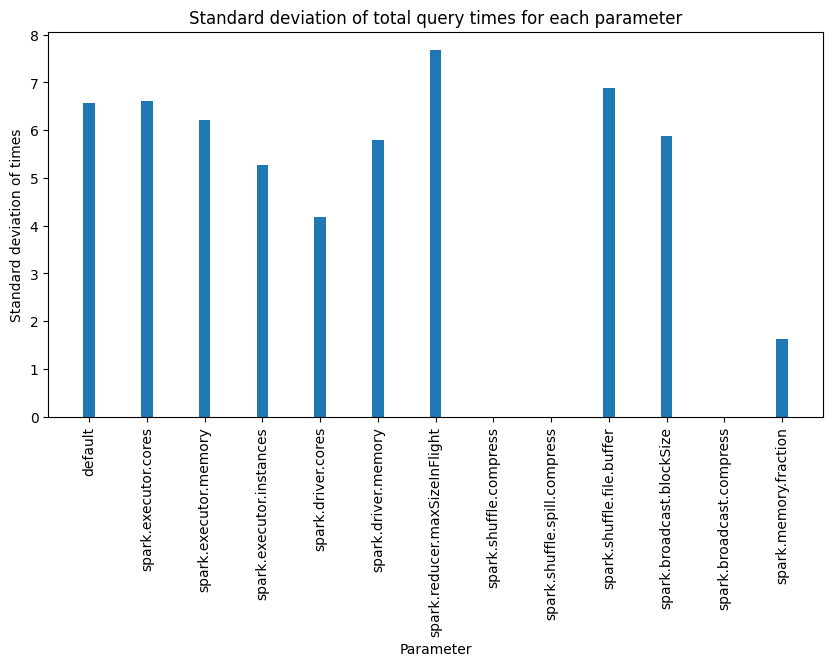

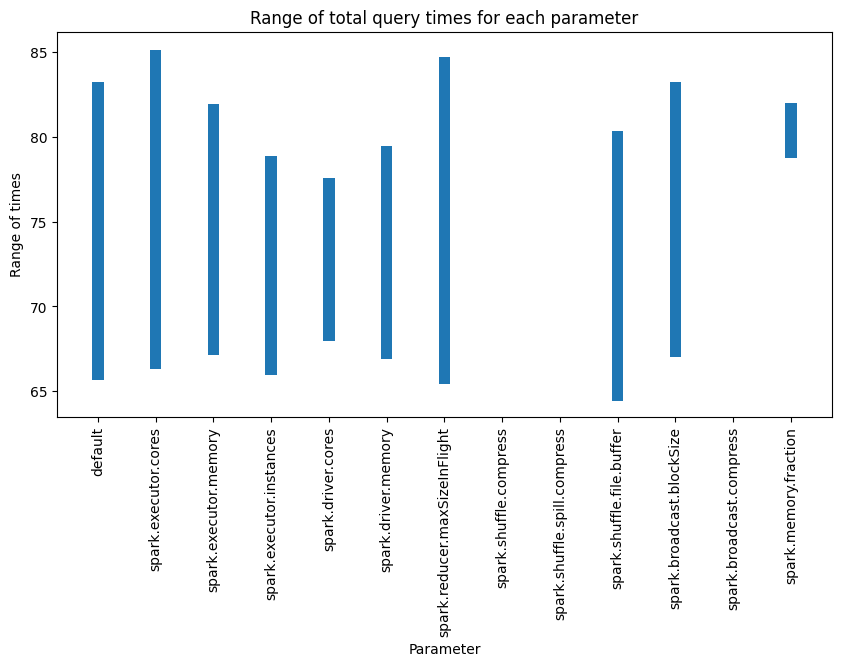

deftotal [1.310380458831787, 1.3100864887237549, 1.323552131652832, 1.4297122955322266, 1.307642936706543, 1.4427781105041504, 1.3065600395202637, 1.501037359237671, 1.5401873588562012, 1.2811477184295654]
default, min: 1.28115, max: 1.54019, median 1.31697, avg: 1.37531  default: (1.28115, 1.54019)
sf10_det_test_log_det


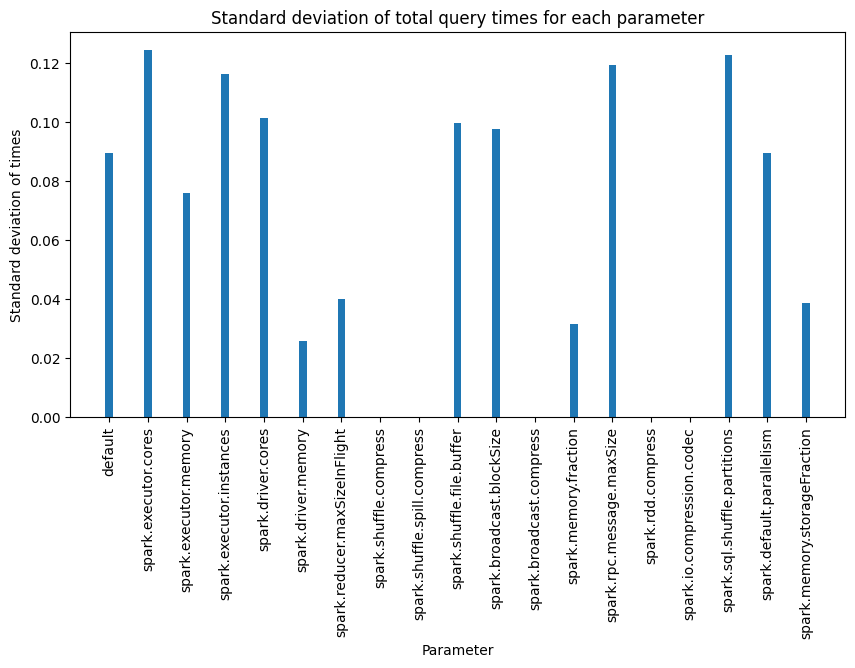

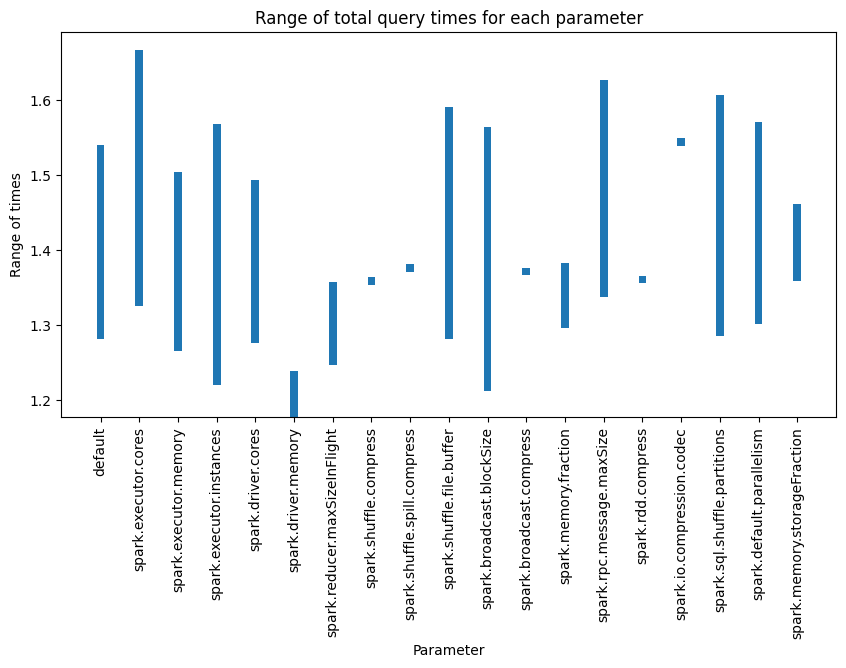

deftotal [2.104457139968872, 1.965604543685913, 1.7544336318969727, 2.1981308460235596, 2.0460996627807617, 1.8441500663757324, 2.003819227218628, 2.0407001972198486, 1.817453145980835, 1.8633522987365723]
default, min: 1.75443, max: 2.19813, median 1.98471, avg: 1.96382  default: (1.75443, 2.19813)
sf324_det_test_big_log_det


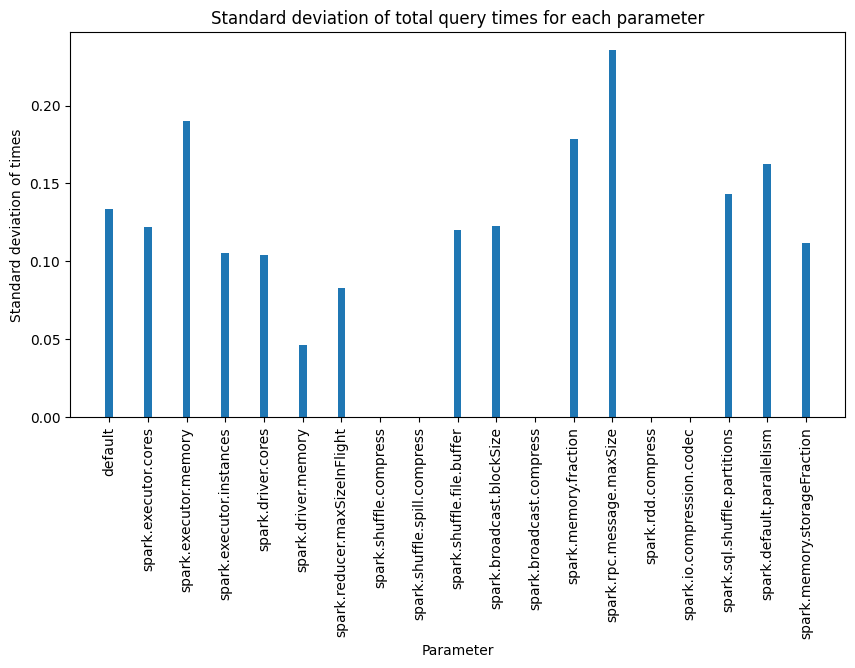

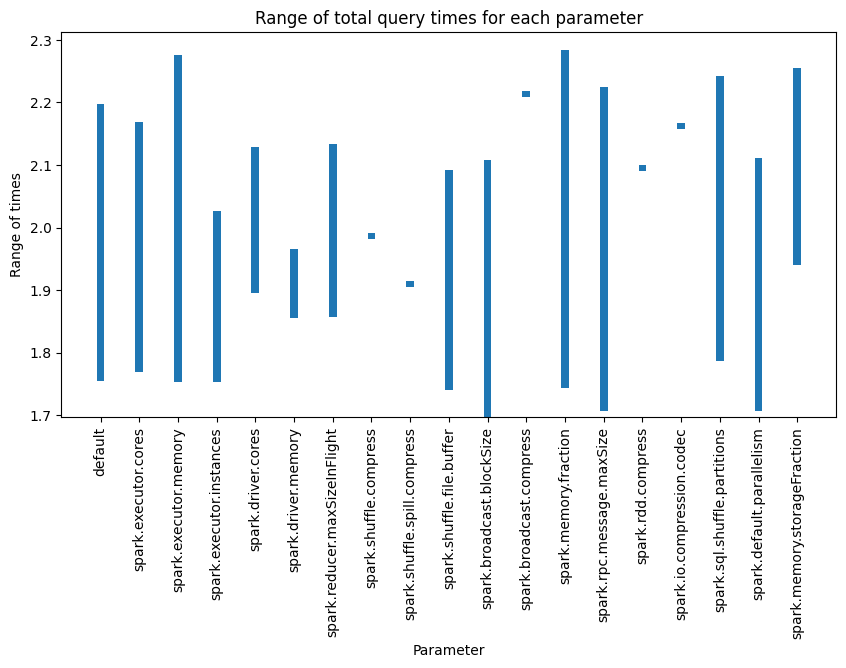

In [21]:
#training_fnames = ['./training_results/'+x for x in os.listdir('./training_results') if 'json' in x and 'test_clear_ports' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'
#training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'json' in x and 'nobackup_deterministic_raw_runtimes' in x]
direc = './training_results'
print(os.listdir(direc))
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'det' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'

len(training_fnames)
print(training_fnames)
for FNAME in  training_fnames:
    import json
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    with open(FNAME,'r') as file:
        try:
            file_data = file.readlines()
        except Exception as e:
            print(FNAME, "load error")
            print(e)
            continue
    if len(file_data) < 5:
        continue

    class Parameter:
        def __init__(self, name):
            self.name = name
            self.val_to_results = {}

        def add(self, param_val, results):
            self.val_to_results[param_val] = results

        def get_total(self, param_val):
            if param_val in self.val_to_results:
                return self.val_to_results[param_val]["total"]

        def get_param_vals(self):
            return set(self.val_to_results.keys())

    param_name_to_param_obj = {}

    def populate_params():
        #analyze one file

        with open(FNAME, "r") as file:
            for line in file:
                d = eval(line)
       
                params = [p for p in d["params"] if p['spark_param']]
                runtimes = d["runtimes"]
                if len(runtimes) == 0:
                    continue

                all_default = True
                for p in params:
                    if str(p['cur_value']) != str(p['default_value']):
                        varying_param = p['name']
                        all_default = False
                        break
                if all_default:
                    if 'default' not in param_name_to_param_obj:
                        param_name_to_param_obj["default"] = Parameter('default')

                    obj = param_name_to_param_obj["default"]
                    obj.add(len(obj.val_to_results), runtimes)
                    continue

                if varying_param not in param_name_to_param_obj:
                    param_name_to_param_obj[varying_param] = Parameter(varying_param)
                obj = param_name_to_param_obj[varying_param]
                assert "total" in runtimes
                obj.add(p['cur_value'], runtimes)

    def analyze_results():
        populate_params()
        default = param_name_to_param_obj["default"]
        default_total = [default.get_total(k) for k in default.get_param_vals()]
        print('deftotal',default_total)
        mins = []
        names = []
        diffs = []
        stds = []
        for p in param_name_to_param_obj:
            min_runtime = float("inf")
            max_runtime = -float("inf")
            times = []
            if p != 'default':
                obj = param_name_to_param_obj[p]
                for k in obj.get_param_vals():
                    total_time = obj.get_total(k)
                    if type(total_time) == list:
                        times.extend(total_time)
                        min_runtime = min(min_runtime, min(total_time))
                        max_runtime = max(max_runtime, max(total_time))
                    else:
                        times.append(total_time)
                        min_runtime = min(min_runtime, total_time)
                        max_runtime = max(max_runtime, total_time)
                if min_runtime == max_runtime:
                    max_runtime += .01


            else:
                times.extend(default_total)
                min_runtime = min(default_total)
                max_runtime = max(default_total)
            stds.append(np.std(times))
            if p == 'default':
                print(f"{p}, min: {round(min_runtime,5)}, max: {round(max_runtime,5)}, median {round(np.median(times),5)}, avg: {round(np.average(times),5)}  default: {round(min(default_total),5), round(max(default_total),5)}")
            mins.append(min_runtime)
            diffs.append(max_runtime - min_runtime)
            names.append(p)

        #save total time std to csv
        df = pd.DataFrame(list(zip(names, stds)),
        columns =['name', 'standard_dev_total_times'])
        df.to_csv("./training_sensitivity/all_runtime_stds.csv", mode='w')

        #plot std
        fig = plt.figure(figsize = (10, 5))
        plt.xticks(rotation=90)
        plt.bar(names, stds, bottom=[0]*len(names), width=0.2)
        plt.title("Standard deviation of total query times for each parameter")
        plt.xlabel("Parameter")
        plt.ylabel("Standard deviation of times")
        name = FNAME.split("/")[-1][:-4]
        print(name)
        plt.savefig(f"./training_sensitivity/all_runtime_stds{name}.jpg", bbox_inches="tight")
        plt.show()

        #plot min/max times for each parameter
        fig = plt.figure(figsize = (10, 5))
        plt.xticks(rotation=90)
        plt.bar(names, diffs, bottom=mins, width=0.2)
        plt.title("Range of total query times for each parameter")
        plt.xlabel("Parameter")
        plt.ylabel("Range of times")
        plt.savefig(f"./training_sensitivity/all_runtime_ranges{name}.jpg", bbox_inches="tight")
        plt.show()

    analyze_results()

In [23]:

#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'
#training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'rand' in x]
direc = './training_results'
training_fnames += [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'rand' in x]
len(training_fnames)
print(training_fnames)

fname_numdata = {'all':0}

for fname in training_fnames:
    with open(fname,'r') as file:
        try:
            file_data = file.readlines()
            fname_numdata[fname] = len(file_data)
            fname_numdata['all'] += len(file_data)
        except:
            print("error loading", fname)
print(sum(fname_numdata.values()))

# how many different param combos have we tried?
fname_num_params = {'all':set()}
fname_valid = {'all':0}
for fname in training_fnames:
    with open(fname,'r') as file:
        try:
            file_data = file.readlines()
        except:
            print("error loading", fname)
            continue
        fname_num_params[fname] = set()
        fname_valid[fname] = 0
        for result_dict in file_data:
            result_dict = eval(result_dict)
            fname_num_params[fname].add(get_spark_params(result_dict))
            fname_valid[fname] += 1 if result_dict['runtimes'] else 0
            fname_num_params['all'].add(get_spark_params(result_dict))
            fname_valid['all'] += 1 if result_dict['runtimes'] else 0
print(sum([len(x) for x in fname_num_params.values()]))
for fname, vals in fname_num_params.items():
    if fname == 'all':
        print("all:")

    print(fname[100:160], '\nnum unique params', len(vals), 'total runs',fname_numdata[fname] , 'valid runs', fname_valid[fname])

['./training_results/sf10_det_local_individual_job.txt', './training_results/sf10_det_main_det.txt', './training_results/sf10_det_test_logging.txt', './training_results/sf10_det_test_log_det.txt', './training_results/sf324_det_test_big_log_det.txt', './training_results/sf10_rand_test_logging_rand.txt']
4592
325
all:
 
num unique params 91 total runs 2296 valid runs 2275
 
num unique params 0 total runs 0 valid runs 0
 
num unique params 54 total runs 532 valid runs 532
 
num unique params 1 total runs 1 valid runs 1
 
num unique params 88 total runs 880 valid runs 870
 
num unique params 88 total runs 880 valid runs 870
 
num unique params 3 total runs 3 valid runs 2
